# Handypreisanalyse

In [1]:
import requests
import pandas as pd
import time
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import os

import altair as alt
plt.xkcd()

## Data Generation

In [2]:
product_list = [
    ['Samsung Galaxy S Series', 'Galaxy S1', 535151],
    ['Samsung Galaxy S Series', 'Galaxy S2', 615532],
    ['Samsung Galaxy S Series', 'Galaxy S3', 772300],
    ['Samsung Galaxy S Series', 'Galaxy S4', 917778],
    ['Samsung Galaxy S Series', 'Galaxy S5', 1075683],
    ['Samsung Galaxy S Series', 'Galaxy S6', 1237277],
    ['Samsung Galaxy S Series', 'Galaxy S7', 1397048],
    ['Samsung Galaxy S Series', 'Galaxy S8', 1601178],
    ['Samsung Galaxy S Series', 'Galaxy S9', 1776751],
    
    ['Samsung Galaxy A Series', 'A3 A300F', 1189008],
    ['Samsung Galaxy A Series', 'A3 (2016) A310F', 1365175],
    ['Samsung Galaxy A Series', 'A3 (2017) A320F', 1556702],
    ['Samsung Galaxy A Series', 'A5 A500F', 1189067],
    ['Samsung Galaxy A Series', 'A5 (2016) A510F', 1365246],
    ['Samsung Galaxy A Series', 'A5 (2017) A520F', 1556679], 
    ['Samsung Galaxy A Series', 'A6 (2018) A600FN', 1812313], 

    #['Apple', 'iPhone 4 16GB', 538203], #unplausible first prices
    ['Apple', 'iPhone 4s 16GB', 687504],
    ['Apple', 'iPhone 5 16GB', 837396],
    ['Apple', 'iPhone 5s 16GB', 999650],
    ['Apple', 'iPhone 6 16GB', 1163683],
    ['Apple', 'iPhone 6s 16GB', 1322858],
    ['Apple', 'iPhone 7 32GB', 1504539],
    ['Apple', 'iPhone 8 64GB', 1688628],
    #['Apple', 'iPhone X 64GB', 1688629],

    #['Google', 'Nexus 4 16GB', 859912],
    #['Google', 'Nexus 5 16GB', 1025573],
    #['Google', 'Nexus 6 32GB', 1181033],
    #['Google', 'Nexus 5X 32GB', 1331033],
    #['Google', 'Nexus 6P 32GB', 1331035],
    ['Google', 'Pixel 32GB', 1517774],
    ['Google', 'Pixel 128GB schwarz', 1517777],
    ['Google', 'Pixel XL 32GB schwarz', 1517767],
    ['Google', 'Pixel XL 128GB schwarz', 1517771],
    ['Google', 'Pixel 2 64GB', 1704861],
    ['Google', 'Pixel 2 128GB', 1704902],
    ['Google', 'Pixel 2 XL 64GB', 1704884],
    ['Google', 'Pixel 2 XL 128GB', 1517771],
    
    #['Blackberry', 'Leap', 1237890],
    #['Blackberry', 'Priv', 1341632],
    #['Blackberry', 'DTEK50', 1482972],
    #['Blackberry', 'DTEK60', 1517352],
    #['Blackberry', 'BlackBerry KEYone', 1584430],
    
    ['Huawei Mate Series', '7', 1162295],
    ['Huawei Mate Series', '8 32GB', 1362456],
    ['Huawei Mate Series', '9 Dual-SIM', 1570816],
    ['Huawei Mate Series', '10 Dual-SIM', 1711349],
    
    ['Huawei P Series', 'Ascend P7 schwarz', 1110750],
    ['Huawei P Series', 'P8 schwarz', 1257393],
    ['Huawei P Series', 'P9 32GB grau', 1422604],
    ['Huawei P Series', 'P10 Single-SIM schwarz', 1584066],
    ['Huawei P Series', 'P20 Single-SIM schwarz', 1795306]
]

In [3]:
def scrapePrices(product_list):
    df_raw = pd.DataFrame()

    for product in product_list:
        url = 'https://geizhals.de/?phist='+str(product[2])+'&age=9999'
        print(url)
        r = requests.get(url).text

        prices = r.split('_gh.plot(')[1].split(', ')[1]
        prices = ast.literal_eval(prices)

        df = pd.DataFrame.from_dict(prices)
        df.columns = ['timestamp', 'price']
        
        df['manufacturer'] = product[0]
        df['product'] = product[1]
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['market_day'] = df.index   

        df = df[df['market_day'] < 1095]   
        
        df['price_avg_week'] = df['price'].rolling(7).mean()
        df['price_perc'] = df['price'] / df['price'][1:3].mean()
        df['price_perc_week'] = df['price_perc'].rolling(7).mean()
        
        df_raw = df_raw.append(df, ignore_index=True)
        time.sleep(2.5)
    return df_raw

In [4]:
df_raw = scrapePrices(product_list)
df_raw.to_csv('../data/raw/prices.csv', sep='\t', encoding='utf-8')

https://geizhals.de/?phist=535151&age=9999
https://geizhals.de/?phist=615532&age=9999
https://geizhals.de/?phist=772300&age=9999
https://geizhals.de/?phist=917778&age=9999
https://geizhals.de/?phist=1075683&age=9999
https://geizhals.de/?phist=1237277&age=9999
https://geizhals.de/?phist=1397048&age=9999
https://geizhals.de/?phist=1601178&age=9999
https://geizhals.de/?phist=1776751&age=9999
https://geizhals.de/?phist=1189008&age=9999
https://geizhals.de/?phist=1365175&age=9999
https://geizhals.de/?phist=1556702&age=9999
https://geizhals.de/?phist=1189067&age=9999
https://geizhals.de/?phist=1365246&age=9999
https://geizhals.de/?phist=1556679&age=9999
https://geizhals.de/?phist=1812313&age=9999
https://geizhals.de/?phist=687504&age=9999
https://geizhals.de/?phist=837396&age=9999
https://geizhals.de/?phist=999650&age=9999
https://geizhals.de/?phist=1163683&age=9999
https://geizhals.de/?phist=1322858&age=9999
https://geizhals.de/?phist=1504539&age=9999
https://geizhals.de/?phist=1688628&age=

In [5]:
df_raw = pd.read_csv('../data/raw/prices.csv', sep='\t', encoding='utf-8')
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

## Analyse

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


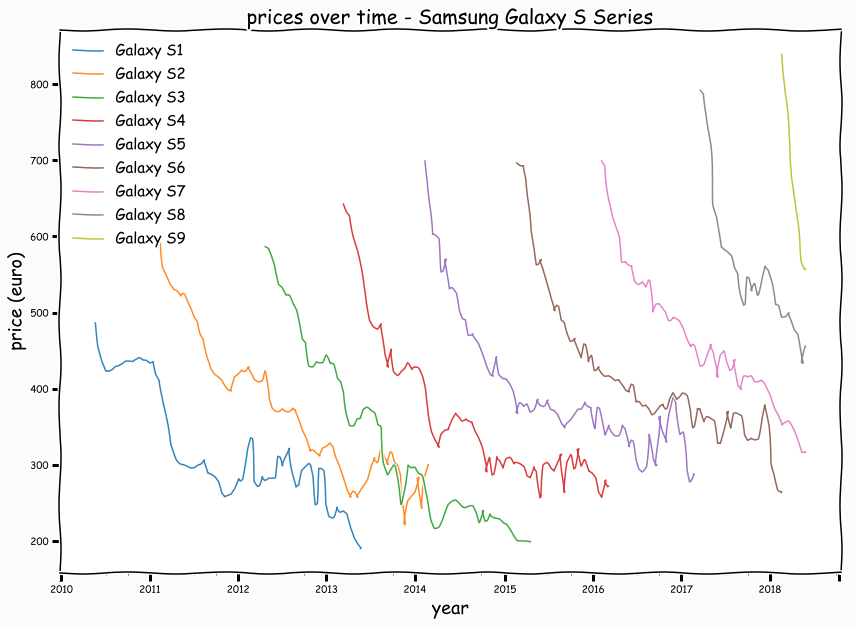

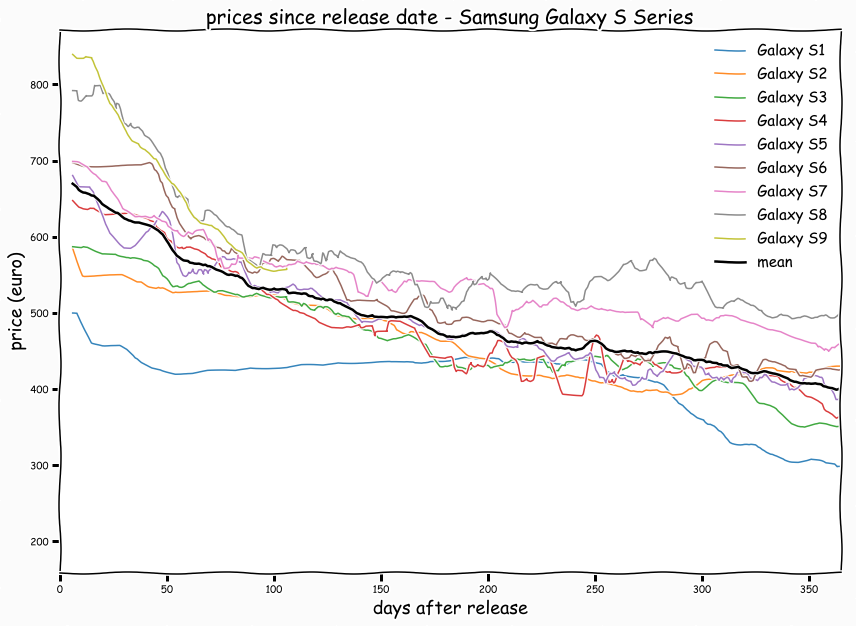

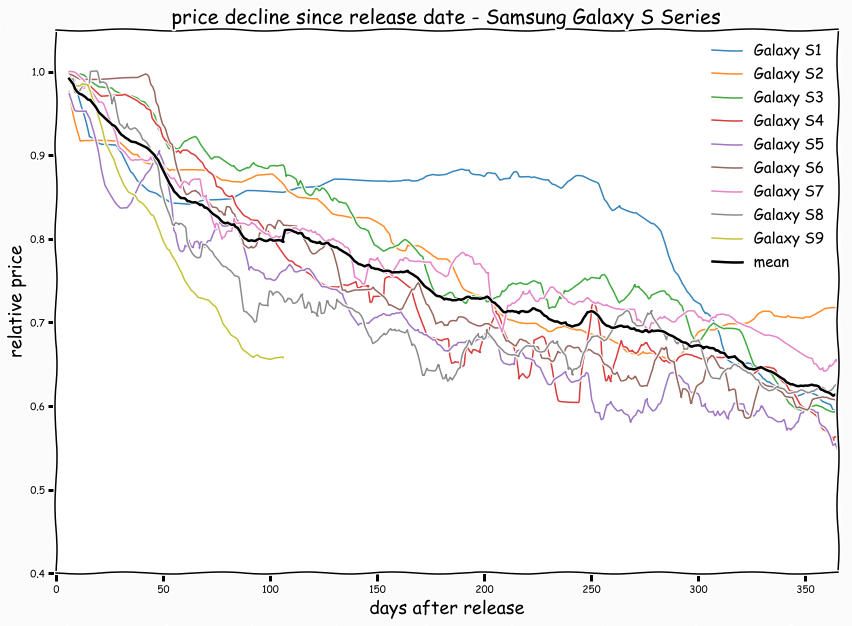

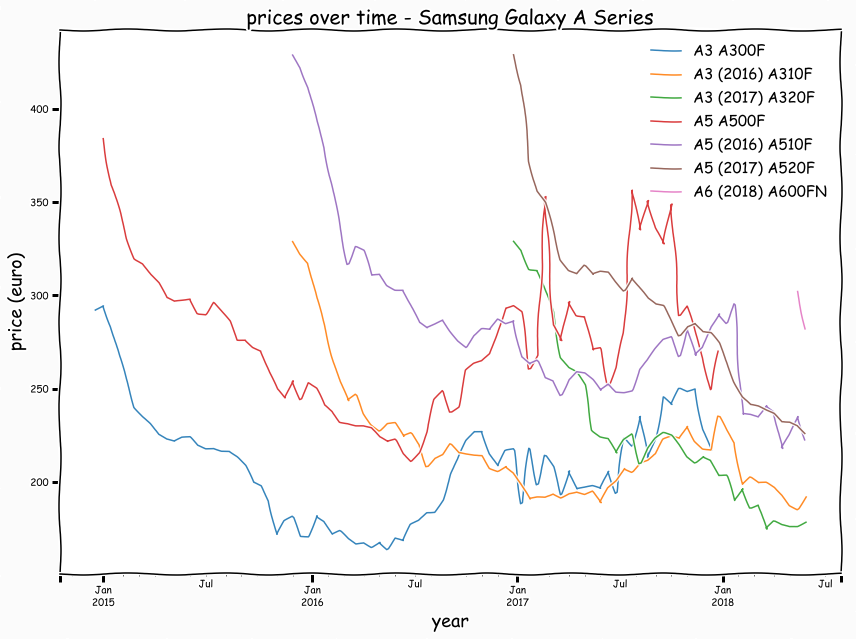

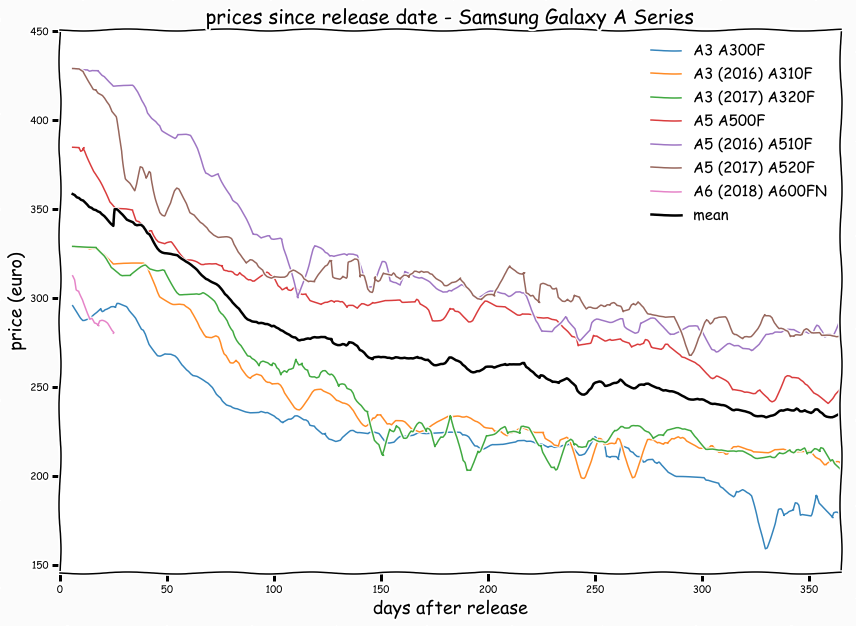

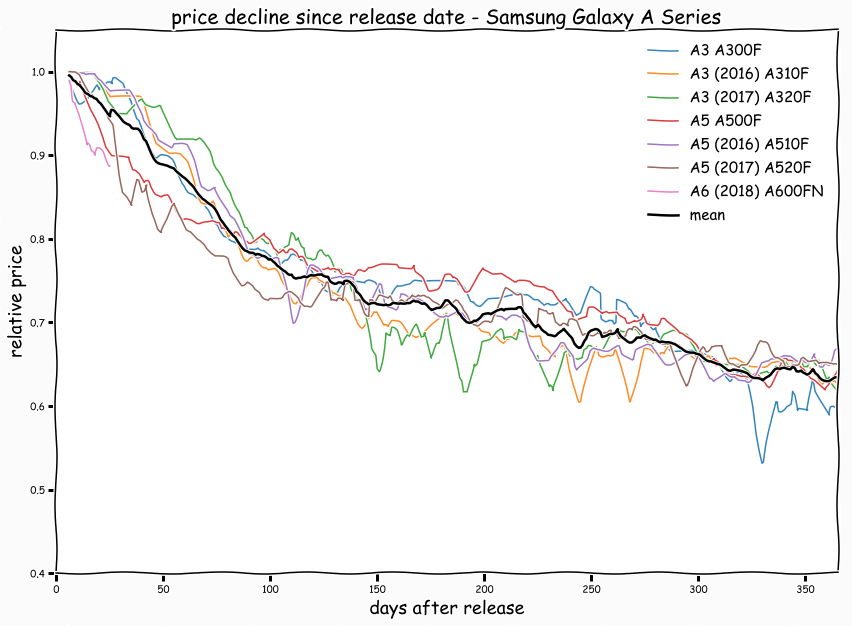

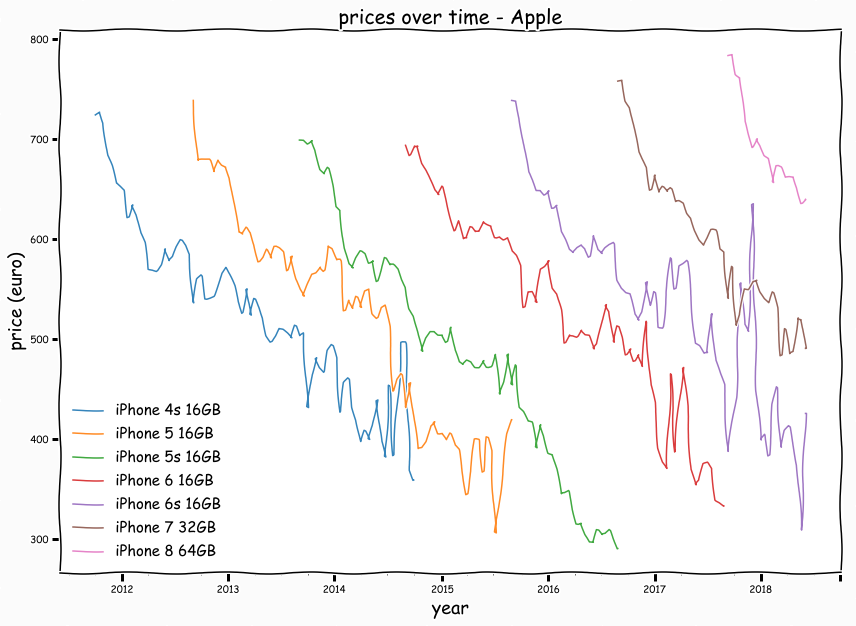

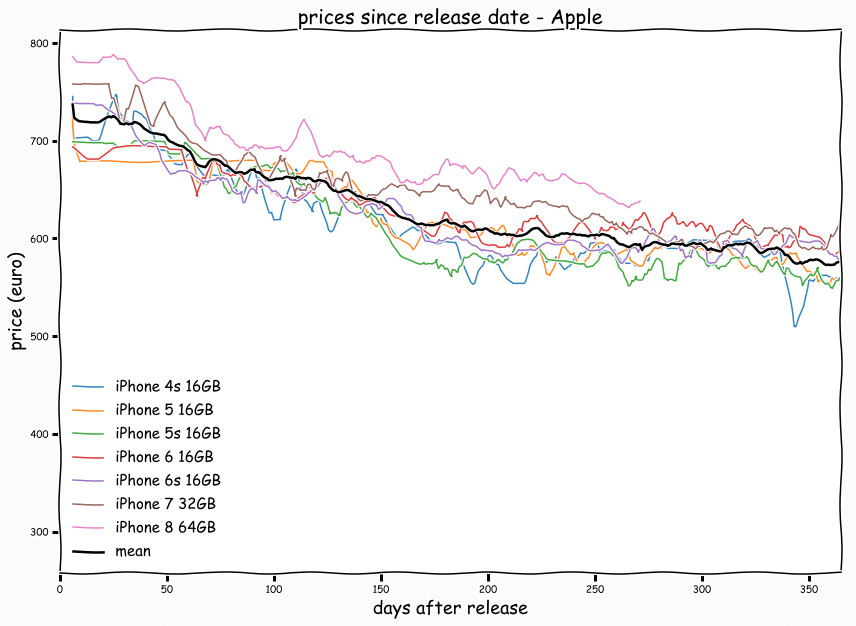

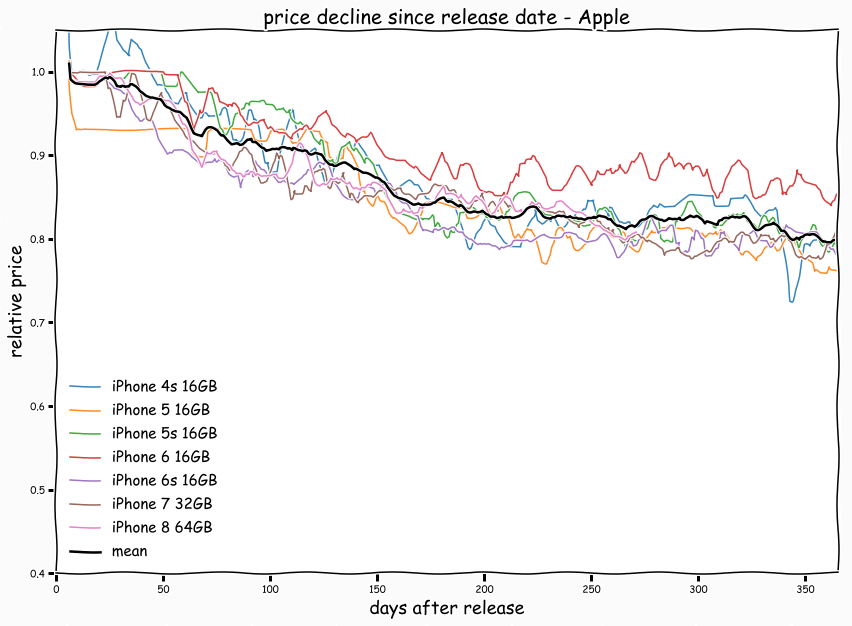

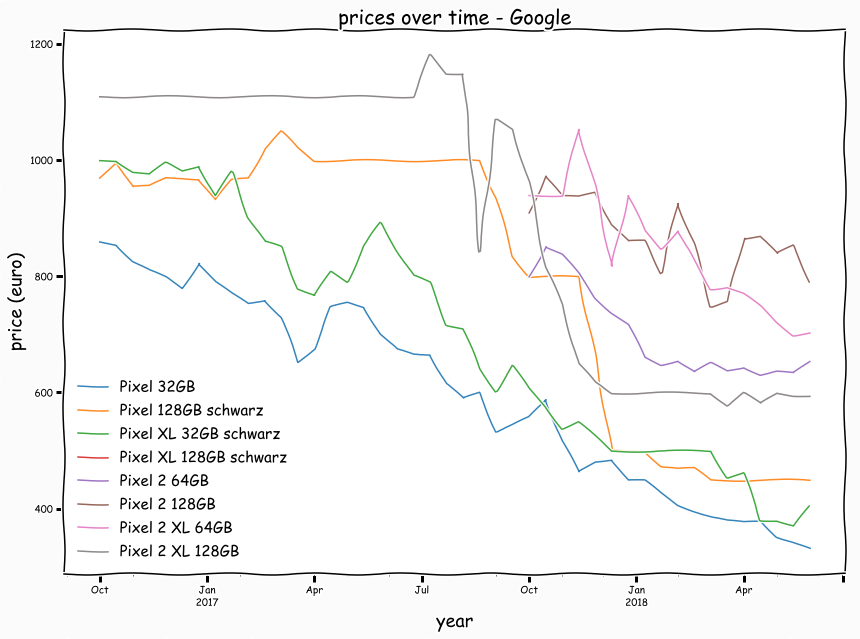

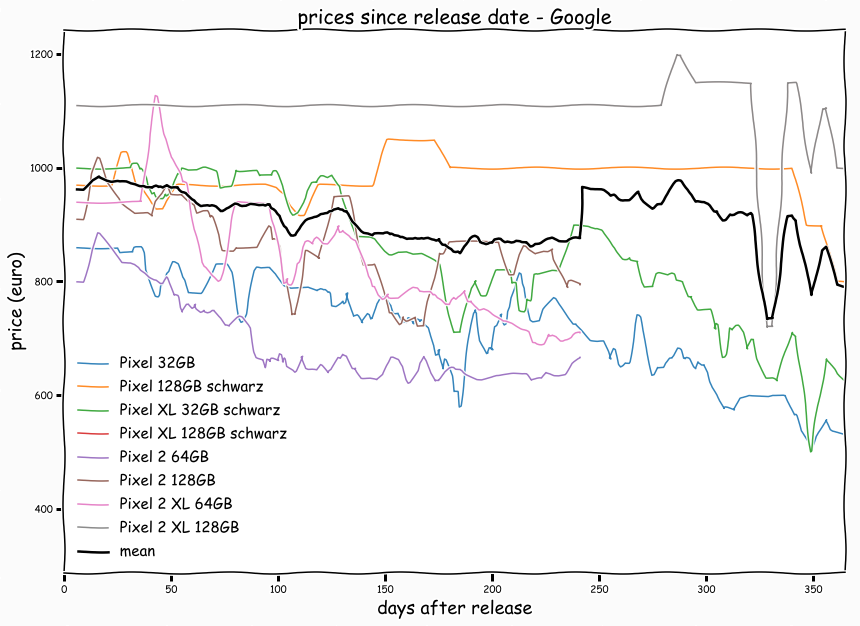

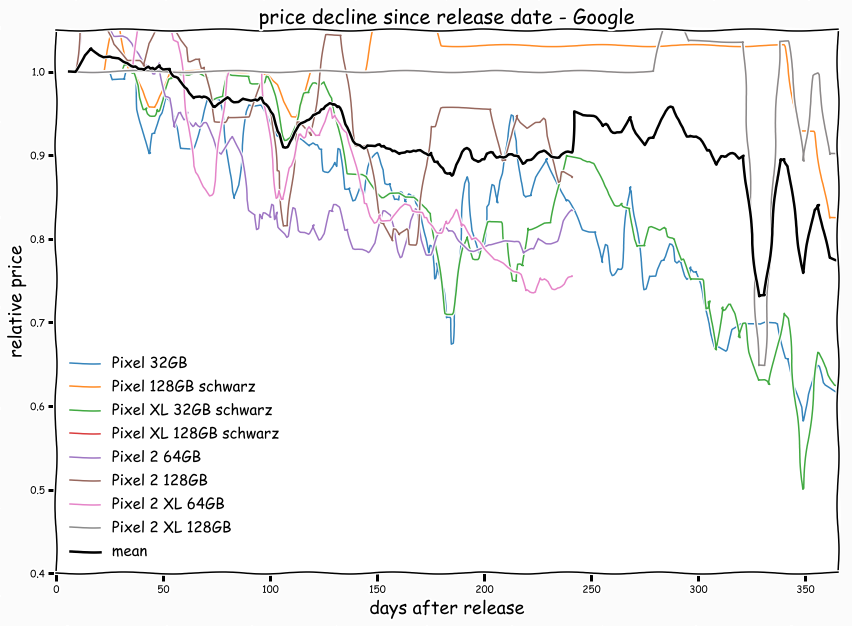

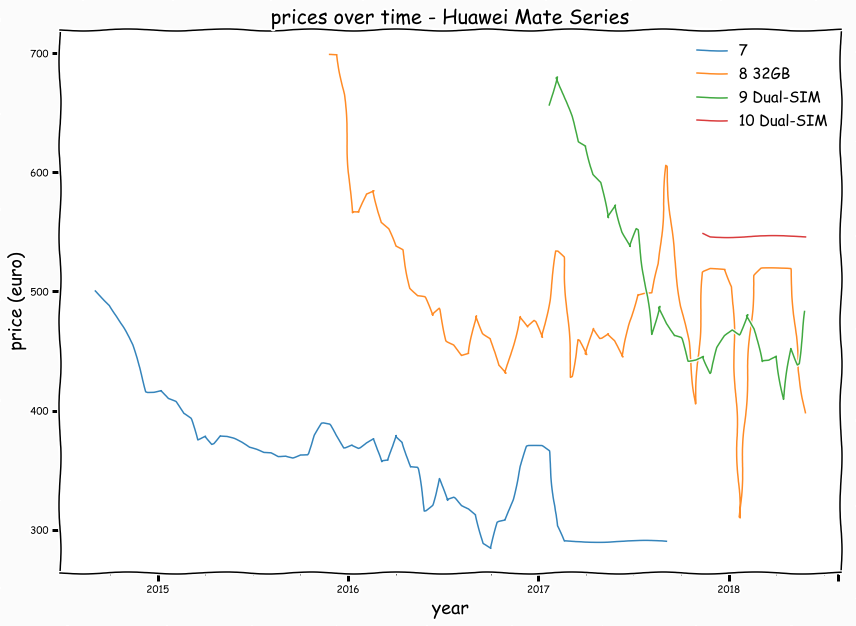

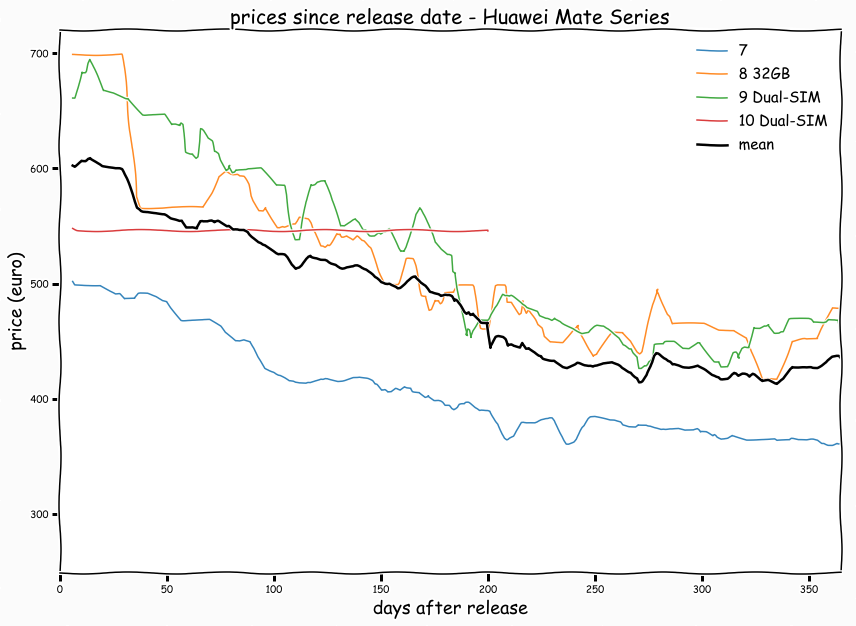

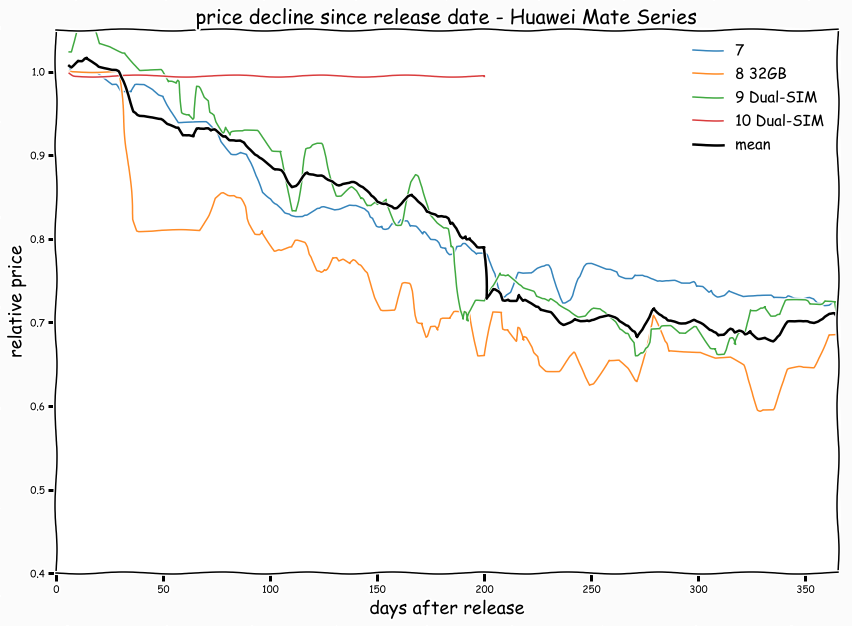

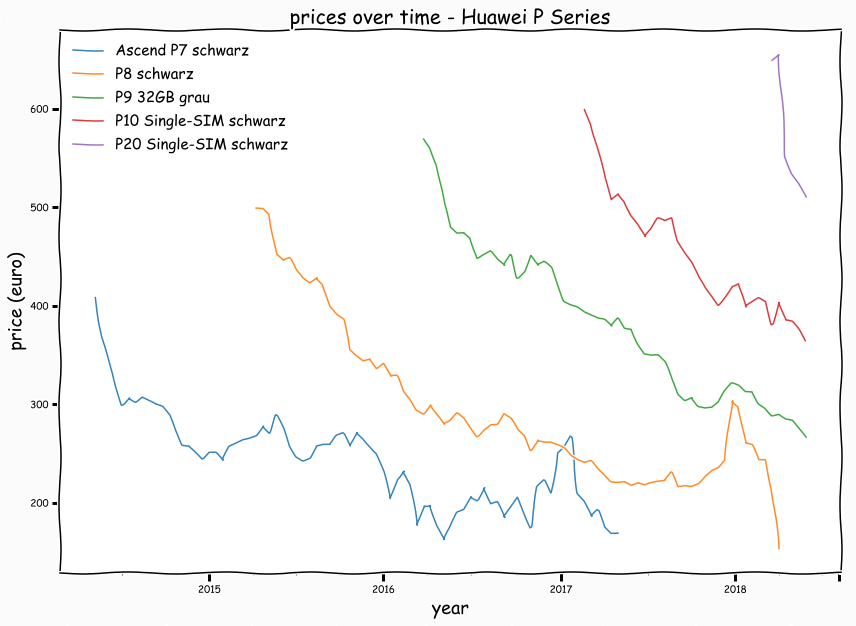

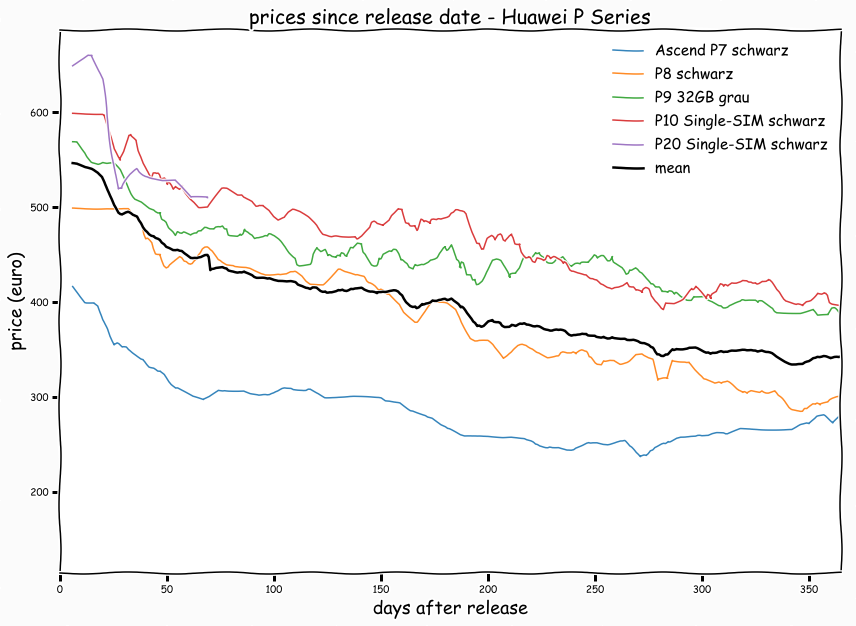

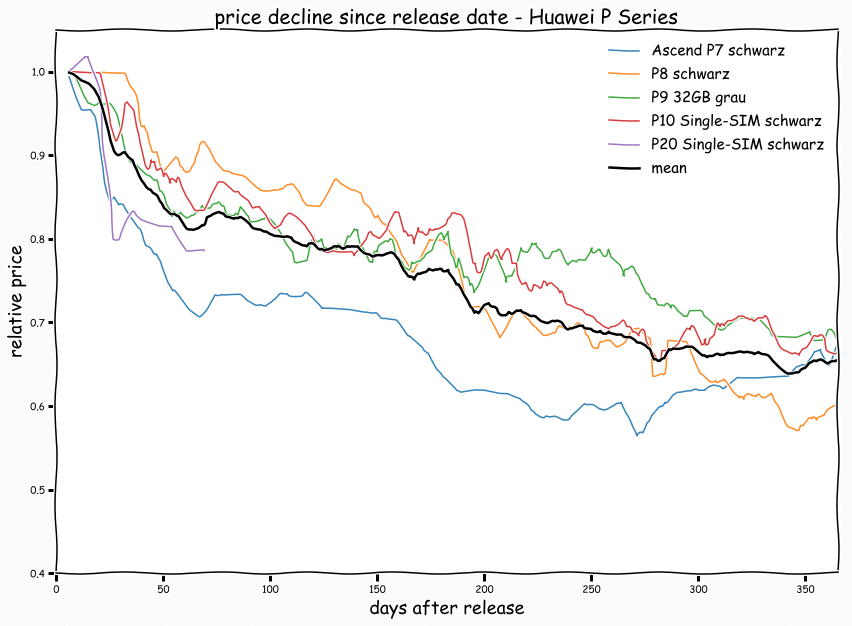

In [7]:
out_image_filetype = 'png'
manufacturer_list = df_raw['manufacturer'].unique().tolist()

for manufacturer in manufacturer_list:

    df_manufacturer = df_raw.loc[df_raw['manufacturer'] == manufacturer]
    product_names = df_manufacturer['product'].unique().tolist()

    title = 'prices over time - '+ manufacturer
    df_figure = df_manufacturer.pivot_table(index='timestamp', columns='product', values='price').resample('14D').mean()
    ax = df_figure.plot(y=product_names, kind="line", figsize=(14, 10), linewidth=1.5, alpha=0.9)
    plt.title(title, fontsize=20)
    plt.xlabel('year', fontsize=18)
    plt.ylabel('price (euro)', fontsize=18)
    plt.legend(title=None, fontsize=15, frameon=False)
    fig = ax.get_figure()
    fig.patch.set_facecolor('#fbfbfb')
    outfile = '01_'+title+'.'+out_image_filetype
    fig.savefig(os.path.join('../figures', outfile), facecolor=fig.get_facecolor(), bbox_inches='tight')
    outfile_xlsx = title+'.xlsx'
    df_figure.to_excel(os.path.join('../data/final', outfile_xlsx))
    del ax, fig, df_figure

    title = 'prices since release date - '+ manufacturer
    df_figure = df_manufacturer.pivot_table(index='market_day', columns='product', values='price_avg_week')
    df_figure['mean'] = df_figure.mean(axis=1)
    ax = df_figure.plot(y=product_names, kind="line", figsize=(14, 10), xlim=(0, 365), linewidth=1.5, alpha=0.9)
    plt.plot(df_figure['mean'], color='black', linewidth=2.5)
    plt.title(title, fontsize=20)
    plt.xlabel('days after release', fontsize=18)
    plt.ylabel('price (euro)', fontsize=18)
    plt.legend(title=None, fontsize=15, frameon=False)
    fig = ax.get_figure()
    fig.patch.set_facecolor('#fbfbfb')
    outfile = '02_'+title+'.'+out_image_filetype
    fig.savefig(os.path.join('../figures', outfile), facecolor=fig.get_facecolor(), bbox_inches='tight')
    outfile_xlsx = title+'.xlsx'
    df_figure.to_excel(os.path.join('../data/final', outfile_xlsx))    
    del ax, fig, df_figure

    title = 'price decline since release date - '+ manufacturer
    df_figure = df_manufacturer.pivot_table(index='market_day', columns='product', values='price_perc_week')
    df_figure['mean'] = df_figure.mean(axis=1)
    ax = df_figure.plot(y=product_names, kind="line", figsize=(14, 10), xlim=(0, 365), ylim=(0.4, 1.05), linewidth=1.5, alpha=0.9)
    plt.plot(df_figure['mean'], color='black', linewidth=2.5)
    plt.title(title, fontsize=20)
    plt.xlabel('days after release', fontsize=18)
    plt.ylabel('relative price', fontsize=18)
    plt.legend(title=None, fontsize=15, frameon=False)
    fig = ax.get_figure()
    fig.patch.set_facecolor('#fbfbfb')
    outfile = '03_'+title+'.'+out_image_filetype
    fig.savefig(os.path.join('../figures', outfile), facecolor=fig.get_facecolor(), bbox_inches='tight')
    outfile_xlsx = title+'.xlsx'
    df_figure.to_excel(os.path.join('../data/final', outfile_xlsx))
    del ax, fig, df_figure